#  Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [1]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['/Users/Samuel/Desktop/Development/Git_Hub/Praticas_IC/TP_Regressao_Logistica-pt2/CI_Logistic_Regression-pt2']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [3]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [4]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [7]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

5948    0
6759    4
2898    2
2511    4
1463    5
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

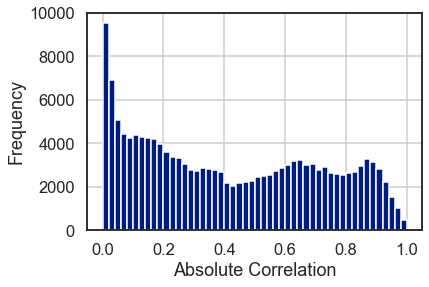

In [11]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']


In [14]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=500, penalty='none').fit(X_train, y_train)
lr.coef_

array([[-1.12753241e+02,  2.17473305e+01,  2.45980653e+01, ...,
         9.53565032e+02, -3.76644087e+02, -6.82954926e+01],
       [-3.63002811e+02, -1.45168850e+02,  4.20596431e+01, ...,
        -9.63621538e+01, -1.91236271e+02, -1.29107255e+02],
       [ 1.68917715e+02,  1.10952883e+02,  1.22638853e+02, ...,
        -4.20272436e+02,  3.28980342e+02,  1.70286659e+01],
       [-8.56589782e+00, -2.41487603e+01,  3.06382555e+00, ...,
        -1.76212251e+02,  1.14312819e+01,  8.12989496e+01],
       [ 2.30427066e+02,  5.25608146e+01,  3.51594570e-01, ...,
        -3.66623233e+02, -3.00660366e+01, -1.88568620e+01],
       [ 8.49771695e+01, -1.59434179e+01, -1.92711982e+02, ...,
         1.05905042e+02,  2.57534771e+02,  1.17931994e+02]])

In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [18]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

In [18]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train, y_train)

### Breve explicação:

Foram expostos os coeficientes de cada regressão logistica com o seus respectivos algoritmos de solução. Houve uma demora considerável com o uso do algoritmo 'liblinear', isso se dá pelo fato que o algoritmo 'liblinear' usar o método de resolução 'um por todos' (onde cada conjunto de dados de uma classe é comparada com o conjunto de dados das outras restantes) esse, é mais viável para um conjunto de dados menor. Esses algoritmos de otimização possuem a vantagem de não precisarem do alfa, como no calculo do gradiente, entretanto com a desvantagem de serem mais complexos.

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [19]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

#for lab,mod in zip(coeff_labels, coeff_models):
#    coeffs = mod.coef_
#    levels=[[lab], [0,1,2,3,4,5]]
#    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
#    coeff_label = pd.MultiIndex(levels,labels)
#    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)



lr                                                              \
              0           1           2           3           4           5   
97   -59.649992  -14.922371   -9.606696   33.357186   90.721522  -39.899648   
42    45.545977  165.456477    9.620236 -107.490633   41.699000 -154.831057   
271  -87.091680 -249.626700  -70.751798   39.736807  103.407151  264.326220   
177   -8.241733   11.547459   87.121698  -77.434152   51.592224  -64.585497   
100 -119.108632 -155.301622  -82.370272  212.993440 -139.396326  283.183414   
189  104.476076  -79.683410   96.866913 -121.115338   44.059127  -44.603369   
443  -61.704246 -164.930350  107.816357  -65.665794  269.794875  -85.310843   
514   92.507758  174.844514  300.141322 -392.501951 -224.981567   49.989925   
161   -8.545603  -67.857915   76.566799   99.108920   68.430965 -167.703166   
323   18.781658   32.492862   79.983123  -63.801551   -8.788294  -58.667797   

      l1                                                          l2  \
       0         1         2         3         4         5         0   
97   0.0  0.000000  0.000000 -0.176881 -0.009851 -0.326883 -0.025560   
42   0.0  0.983159 -2.414988  0.000000  0.153273 -1.670107  0.213837   
271  0.0 -1.245471 -0.332047 -0.864534  0.124095  2.503465  0.007356   
177  0.0  0.002897  0.000000 -0.192995  0.093601  0.000000 -0.015066   
100  0.0  0.000000  0.000000  0.830827 -1.413640  1.039519 -0.053037   
189  0.0 -2.836080  0.497841 -1.978099  0.491166  1.572514  0.175565   
443  0.0  0.000000  0.000000 -0.262570  0.510387 -0.528451 -0.008482   
514  0.0  0.697367  0.000000 -0.508872  0.000000  0.120072  0.198059   
161  0.0  0.000000  0.000000  1.502717  0.000000 -0.925482  0.004842   
323  0.0  0.456296  0.238259  0.132084  0.084734  0.154913  0.001166   

                                                       
            1         2         3         4         5  
97  -0.022606 -0.054026  0.116069  0.092934 -0.106811  
42   0.381222 -0.496620 -0.107976  0.316849 -0.307313  
271 -0.363352 -0.047749 -0.265855  0.221982  0.447617  
177 -0.032186  0.036511 -0.066964  0.117020 -0.039314  
100 -0.192394 -0.088089  0.389328 -0.526026  0.470217  
189 -0.699882  0.533180 -0.364515  0.214254  0.141399  
443 -0.265631  0.191531 -0.114985  0.431302 -0.233734  
514  0.359423 -0.034190 -0.618735 -0.181822  0.277265  
161 -0.114584  0.123374  0.224178  0.054346 -0.292156  
323 -0.015081  0.015193  0.004456  0.008108 -0.013842

### Breve explicação:

Como sabemos, quando utilizamos a regressão logística para rótulos multiclasse, o modelo encontrará um conjunto de coeficientes para cada classe, devido ao "método um vs resto". Assim, cada modelo contém 6 conjuntos de coeficientes que diferem uns dos outros.

Prepare six separate plots for each of the multi-class coefficients.

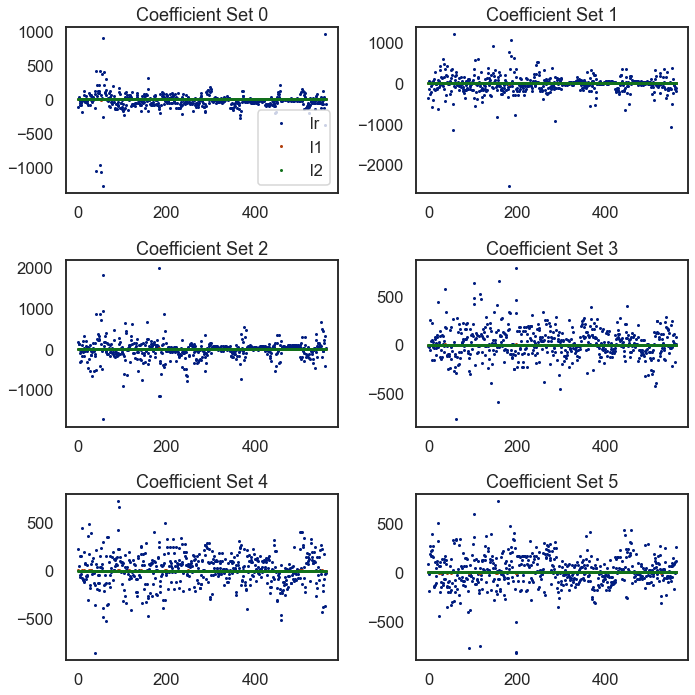

In [20]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()




### Breve explicação:

Nas imagens acime, foi representado graficamente os conjuntos de coeficientes obtidos para a primeira classe com a rotulação por cor nos 3 modelos, em seguida, aplicou-se o mesmo para a segunda classe e sucessivamente.

## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [21]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()



,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [22]:
y_prob.head()

,lr,l1,l2
0,1.0,0.998959,0.999998
1,1.0,0.999576,0.999656
2,1.0,0.995335,0.998874
3,1.0,0.999195,0.997831
4,1.0,0.999918,0.999304


### Breve explicação:

Acima, está sendo exibido duas tabelas que mostram a regressão e a probabilidade para cada curva.

## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [23]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [24]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.980888,0.983835,0.983485
recall,0.980906,0.983819,0.983495
fscore,0.980884,0.983815,0.983488
accuracy,0.980906,0.983819,0.983495
auc,0.988437,0.990144,0.989983


### Breve explicação:

Na tabela acima, não vemos uma diferença estatisticamente significativa nas métricas de erro entre os 3 modelos, mesmo usando apenas o primeiro (sem regularização) podemos esperar um ótimo desempenho na previsão das atividades.

## Question 8

Display or plot the confusion matrix for each model.

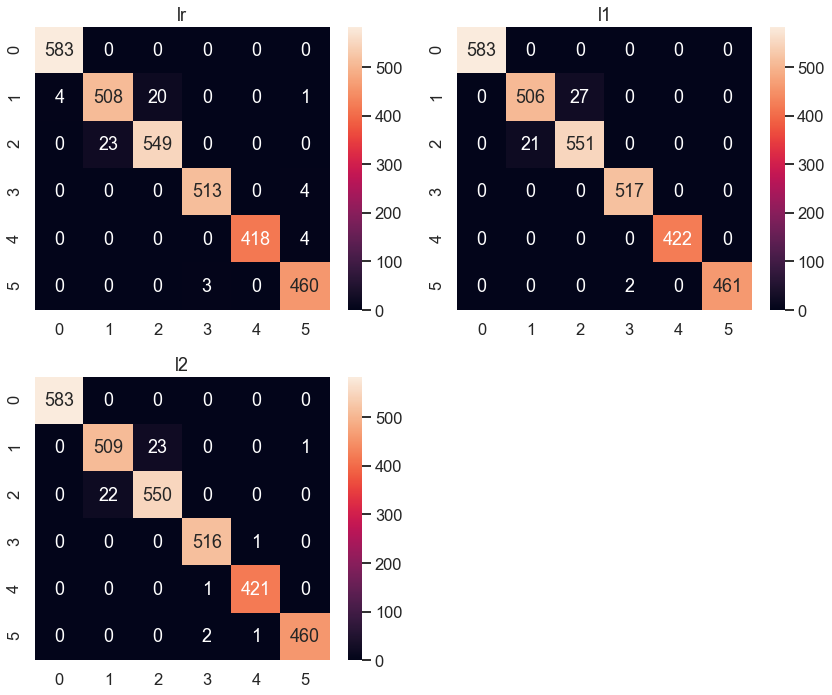

In [25]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


### 

## Question 9
 Identify highly correlated columns and drop those columns before building models

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold


X_data = data.iloc[:, :-1]


#threshold with .7
sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
X_data = pd.DataFrame(sel.fit_transform(X_data))


feature_cols = X_data.columns[:]


# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features
 

X_train_new = X_data.loc[train_idx, :]

y_train_new = data.loc[train_idx, 'Activity']
 
X_test_new  = X_data.loc[test_idx, :]
y_test_new  = data.loc[test_idx, 'Activity']
 
print(X_train.shape)
print(X_train_new.shape)
 
print(X_test.shape)
print(X_test_new.shape)

(7209, 561)
(7209, 50)
(3090, 561)
(3090, 50)


 Repeat Model building with new training data after removing higly correlated columns

In [27]:
# Try standard, L1 and L2 Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Foi necessário aumentar o número de interações em todas as regressões.

# Standard logistic regression
lr_new = LogisticRegression(max_iter=10000, penalty='none').fit(X_train_new, y_train_new)


In [50]:
# L1 regularized logistic regression
lr_l1_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', max_iter=5000).fit(X_train_new, y_train_new)


In [29]:
# L2 regularized logistic regression
lr_l2_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train_new, y_train_new)

In [31]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations


## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [51]:
# Combine all the coefficients into a dataframe for comparison

coefficients_new = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr_new, lr_l1_new, lr_l2_new]

#for lab,mod in zip(coeff_labels, coeff_models):
#    coeffs = mod.coef_
#    levels=[[lab], [0,1,2,3,4,5]]
#    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
#    coeff_label = pd.MultiIndex(levels,labels)
#    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients_new.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients_new = pd.concat(coefficients_new, axis=1)

coefficients_new.sample(10)

lr                                                          l1  \
           0          1          2          3          4          5    0   
34 -4.346637  -2.906370  -2.265775   1.955144   6.482496   1.081143  0.0   
10  3.274028   0.338311   0.835366  -1.140845  -1.953807  -1.353054  0.0   
25  4.277529   1.449504   2.118092 -11.866406   6.190505  -2.169223  0.0   
37 -5.134578  -7.987142  -8.062384   2.394235   5.950411  12.839459  0.0   
13 -5.527292  -8.291256  -9.269856  12.847093   0.807058   9.434253  0.0   
16 -0.990587   2.837459  -1.165508  -0.343814   0.844833  -1.182383  0.0   
48 -1.851074  -2.781182  -2.109419   2.723268   1.681151   2.337257  0.0   
17  0.282950  -2.472762  -4.418700   5.543725  -3.076713   4.141499  0.0   
30 -1.039252 -61.598369  60.108313  89.789118 -68.837616 -18.422194  0.0   
33 -1.605142  -6.031486  -6.246184   1.577948   5.768840   6.536024  0.0   

                                                              l2            \
           1         2          3         4          5         0         1   
34  0.000000  1.856261   1.062979  3.447684   0.401039 -1.675139 -1.667642   
10 -0.506060  0.533437   0.099509 -0.416761   0.330691  1.961253  0.408170   
25 -0.740016  1.547031  -7.291042  8.604277   2.246393  1.255826  0.430444   
37 -2.625487  5.607183  -5.667569  0.659380  11.184632 -1.875778 -4.533359   
13  0.041350 -0.687319   4.742306 -6.168585   2.382131 -1.770805 -4.388288   
16  3.610716 -3.699600  -0.843780  3.887588  -0.890187 -0.453732  2.657831   
48 -0.588316  0.668112   0.250379 -0.499162  -0.028367 -1.049294 -1.270199   
17  1.516783 -1.383951   1.539467 -3.913690   3.246234 -0.958517 -0.430174   
30  0.760888  0.000000  42.505364  2.911328  16.689861  0.482338 -7.695498   
33  1.231368 -0.035932  -2.356913  1.841978   2.774527 -1.220057 -2.776397   

                                              
           2          3          4         5  
34 -0.904415   0.212905   4.646978 -0.612688  
10  0.905463  -0.779766  -1.557516 -0.937604  
25  1.242142  -9.569609   7.475050 -0.833852  
37 -4.253007  -0.092016   1.859523  8.894637  
13 -5.629515   8.997775  -2.785315  5.576149  
16 -1.440870  -0.487850   0.745542 -1.020921  
48 -0.591977   1.344109   0.452276  1.115086  
17 -2.328739   4.170556  -3.665668  3.212542  
30  6.348028  15.854109 -15.939203  0.950226  
33 -3.031909   0.062604   3.122092  3.843667

Prepare six separate plots for each of the multi-class coefficients.

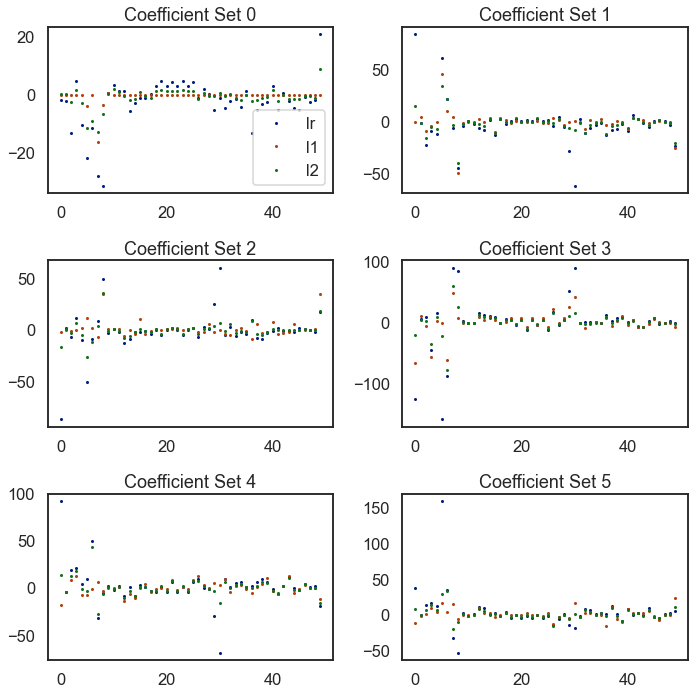

In [52]:
# try the plots

fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients_new.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [53]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr_new, lr_l1_new, lr_l2_new]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [54]:
# Calculate the error metrics as listed above
metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test_new, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test_new, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test_new, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test_new, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [55]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.937076,0.937632,0.936643
recall,0.936893,0.937540,0.936570
fscore,0.936902,0.937536,0.936555
accuracy,0.936893,0.937540,0.936570
auc,0.962166,0.962457,0.961954


## Question 13

Display or plot the confusion matrix for each model.

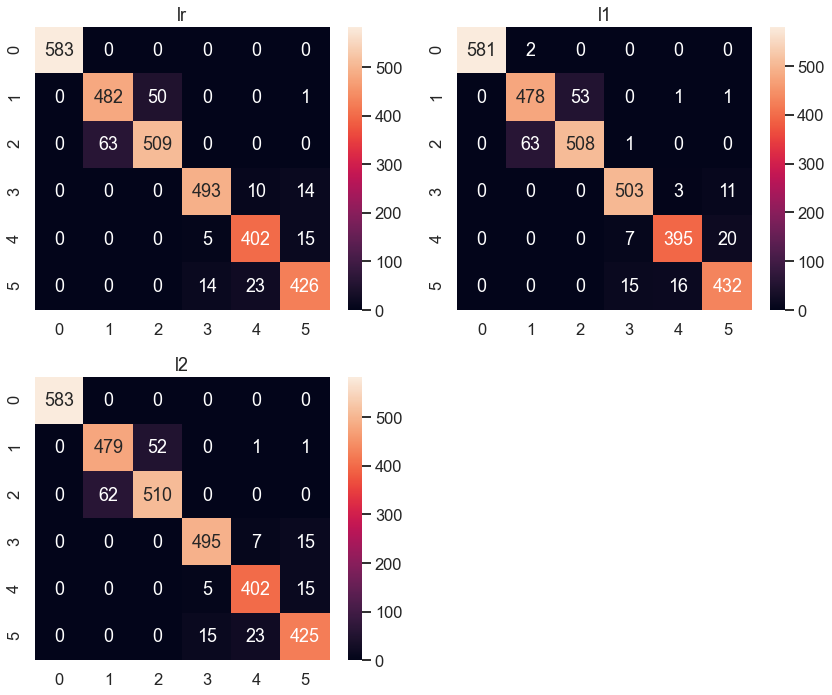

In [56]:
#plot the confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

In [58]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation

Ao reduzir as colunas mais relacionadas foi observado que o modelo teve uma leve diminuição em todos os parâmetros accuracy, prediction, recall, fscore. Portanto para todas as regressões (lr, l1, l2) houve uma leve piora, ou seja, seus valores foram levemente reduzidos.

In [57]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation

Ao comparar as matrizes de confusão, só reforçamos que houve uma leve piora removendo as colunas mais relacionadas.